<a href="https://colab.research.google.com/github/nilu4u/chatbot/blob/main/Chatbot_Deep_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
lines = open('/content/drive/MyDrive/DS_Datas/movie_lines.txt',encoding='utf-8', errors='ignore').read().split('\n')
conversations = open('/content/drive/MyDrive/DS_Datas/movie_conversations.txt',encoding='utf-8', errors='ignore').read().split('\n')

# New Section

In [ ]:
#creating dictionary of ids to lines

id2lines = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if (len(_line)==5):
        id2lines[_line[0]] = _line[-1]

In [ ]:
#creating dictionary of ids to conversations

conversation_ids = []
for conv in conversations[:-1]:
    _conv = conv.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    conversation_ids.append(_conv.split(","))

In [ ]:
questions = []
answers = []

for conv in conversation_ids:
    for i in range(len(conv) -1):
      if len(id2lines[conv[i]].split())<=25 and len(id2lines[conv[i+1]].split())<=25:
        questions.append(id2lines[conv[i]])
        answers.append(id2lines[conv[i+1]])

In [ ]:
len(questions), len(answers)

(188051, 188051)

In [ ]:
max(len(l.split()) for l in answers)

25

In [ ]:
#cleaning data

In [ ]:
def clean(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#/@;:<>{}+=~|?.]","", text)
    return text

In [ ]:
#cleaning questions
clean_questions = []
for question in questions:
    clean_questions.append(clean(question))

In [ ]:
#cleaning answers
clean_answers = []
for answer in answers:
    clean_answers.append(clean(answer))

Train test split

In [ ]:
test_clean_q = clean_questions[188000:]
test_clean_a = clean_answers[188000:]

train_clean_q = clean_questions[:30000]
train_clean_a = clean_answers[:30000]

In [ ]:
word_dic = {}
counter = 1
for question in train_clean_q:
    for word in question.split():
        if word not in word_dic:
            word_dic[word] = counter
            counter += 1

for answer in train_clean_a:
    for word in answer.split():
        if word not in word_dic:
          word_dic[word] = counter
          counter += 1

In [ ]:
#adding id to TOKENS
tokens = ['<EOS>', '<SOS>']
token_count = len(word_dic) + 1
for token in tokens:
    word_dic[token] = token_count
    token_count +=1

In [ ]:
id2words = {id:word for word, id in word_dic.items()}

In [ ]:
#adding EOS to end of answers
for i in range(len(train_clean_a)):
  ans = train_clean_a[i]
  train_clean_a[i]  = '<SOS>'+ ' ' + ans + ' ' +'<EOS>'

In [ ]:
tokenized_que = [[word_dic[word] for word in s.split()] for s in train_clean_q]
tokenized_ans =[[word_dic[word] for word in s.split()] for s in train_clean_a]

In [ ]:
decoding_output = []
for i in tokenized_ans:
  decoding_output.append(i[1:])

# Padding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences 

In [ ]:
max_len = max(max(len(lines) for lines in tokenized_ans),max(len(lines) for lines in tokenized_que))

In [ ]:
decoding_output = []
for i in tokenized_ans:
  decoding_output.append(i[1:])

# Creating the model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

In [ ]:
vocab_size = len(word_dic) + 1

In [ ]:
#Encoder

enc_inp = Input(shape=(max_len,))
q_embed = Embedding(vocab_size, output_dim=50, trainable=True, input_length=max_len, mask_zero=True)

enc_embed = q_embed(enc_inp)
enc_lstm = LSTM(400, return_sequences=True, return_state=True)
_,h,c = enc_lstm(enc_embed)
enc_state=[h,c]

#Decoder

dec_inp = Input(shape=(max_len,))
a_embed = Embedding(vocab_size, output_dim=50, trainable=True, input_length=max_len, mask_zero=True)

dec_embed = a_embed(dec_inp)
dec_lstm = LSTM(400, return_sequences=True, return_state=True)
dc_out,_,_ = dec_lstm(dec_embed, initial_state=enc_state)

dense = Dense(vocab_size, activation='softmax')
dense_out = dense(dc_out)
model = Model([enc_inp, dec_inp], dense_out)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [ ]:
from tensorflow.keras.utils import to_categorical
import gc
epochs = 30
size = len(tokenized_que)
batch_size=100

for epoch in range(epochs):
  #print('epoch: ', epoch)
  for i in range(0,size,batch_size):
    encoding_input_batch = pad_sequences(tokenized_que[i: i+batch_size], max_len, padding='post', truncating='post')
    decoding_input_batch = pad_sequences(tokenized_ans[i: i+batch_size], max_len, padding='post', truncating='post')
    decoding_output_pad = pad_sequences(decoding_output[i: i+batch_size], max_len, padding='post', truncating='post')
    
    #encoding_input_batch = to_categorical(encoding_input_pad, vocab_size)
    #encoding_input_batch = np.array(encoding_input_batch)

    #decoding_input_batch = to_categorical(decoding_input_pad, vocab_size)
    #decoding_input_batch = np.array(decoding_input_batch)

    decoding_output_batch = to_categorical(decoding_output_pad, vocab_size)
    decoding_output_batch = np.array(decoding_output_batch)
    
    print('epoch: ',epoch, ' run: ', i)
    model.fit([encoding_input_batch, decoding_input_batch], decoding_output_batch, epochs=1)
    del(encoding_input_batch, decoding_input_batch, decoding_output_batch, decoding_output_pad)
    gc.collect()

Streaming output truncated to the last 5000 lines.
epoch:  21  run:  20000
4/4 [==============================] - 1s 121ms/step - loss: 0.6113 - acc: 0.4793
epoch:  21  run:  20100
4/4 [==============================] - 1s 126ms/step - loss: 0.6143 - acc: 0.5078
epoch:  21  run:  20200
4/4 [==============================] - 1s 120ms/step - loss: 0.6040 - acc: 0.4589
epoch:  21  run:  20300
4/4 [==============================] - 1s 121ms/step - loss: 0.7135 - acc: 0.4645
epoch:  21  run:  20400
4/4 [==============================] - 1s 127ms/step - loss: 0.7689 - acc: 0.4896
epoch:  21  run:  20500
4/4 [==============================] - 1s 121ms/step - loss: 0.7156 - acc: 0.4536
epoch:  21  run:  20600
4/4 [==============================] - 1s 122ms/step - loss: 0.7462 - acc: 0.4142
epoch:  21  run:  20700
4/4 [==============================] - 1s 124ms/step - loss: 0.6372 - acc: 0.4629
epoch:  21  run:  20800
4/4 [==============================] - 1s 125ms/step - loss: 0.7794 - acc: 0.

In [ ]:
model.save('/content/drive/MyDrive/DS_Datas/chatbot_model.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 50)       1097450     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 50)       1097450     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.history.history

{'acc': [0.5117301940917969], 'loss': [0.4522651731967926]}

In [ ]:
model.weights

[<tf.Variable 'embedding/embeddings:0' shape=(21949, 50) dtype=float32, numpy=
 array([[-0.02614328,  0.00496236,  0.03351493, ...,  0.01906984,
         -0.0206517 , -0.03582106],
        [-0.12037245, -0.00061417, -0.03091706, ...,  0.0713503 ,
          0.03768362, -0.2786695 ],
        [ 0.06253783,  0.08310132,  0.16749477, ..., -0.02381293,
         -0.07990431, -0.02594605],
        ...,
        [ 0.02156207,  0.04684161,  0.04531625, ..., -0.00159987,
          0.01080028, -0.02276068],
        [-0.4866872 ,  0.0566281 ,  0.2886106 , ...,  0.4936776 ,
          0.3154065 , -0.1453176 ],
        [-0.08181678,  0.07911778,  0.02211659, ...,  0.05219015,
          0.07826048, -0.07828172]], dtype=float32)>,
 <tf.Variable 'embedding_1/embeddings:0' shape=(21949, 50) dtype=float32, numpy=
 array([[-4.11291607e-02,  1.31846592e-03, -1.43097714e-03, ...,
          9.72778723e-03,  2.65150331e-02, -3.54926363e-02],
        [-2.36513332e-01, -2.12654889e-01, -2.54614830e-01, ...,
      

In [ ]:
model.save_weights("/content/drive/MyDrive/DS_Datas/chatbot_weights.h5")

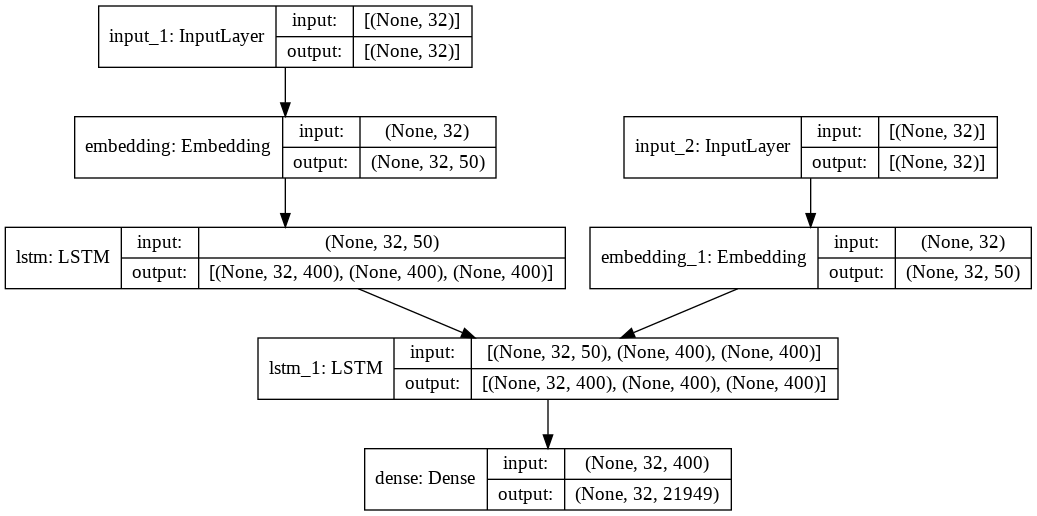

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
from tensorflow import keras

model = keras.models.load_model("/content/drive/MyDrive/DS_Datas/chatbot_model.h5")

Inference model

In [ ]:
def infer_model(inp):
  enc_model = Model([enc_inp], enc_state)

  #decoder model
  dec_inp_state_h = Input(shape=(400,))
  dec_inp_state_c = Input(shape=(400,))

  dec_inp_state = [dec_inp_state_h, dec_inp_state_c]

  dec_out, dec_out_h, dec_out_c = dec_lstm(dec_embed, initial_state=dec_inp_state)

  dec_out_state = [dec_out_h, dec_out_c]

  dec_model = Model([dec_inp]+dec_inp_state, [dec_out]+dec_out_state)

  inpt = enc_model.predict(inp)

  next_word = np.zeros((1,1))
  next_word[0,0] = a_word2id['<SOS>']

  decoded_translation =''

  stop_condition = False

  while not stop_condition:
    dec_output, h,c = dec_model.predict([next_word]+inpt)
    decoder_output = dense_out.predict(dec_output)

    sampled_word_index = np.argmax(decoder_output[0,-1, :])
    sampled_word = a_id2words[sampled_word_index]

    if sampled_word != '<EOS>':
      decoded_translation += sampled_word

    if sampled_word == '<EOS>' or len(decoded_translation.split())>25:
      stop_condition=True
    
    next_word = np.zeros((1,1))
    next_word[0,0] = sampled_word_index
    inpt = [h,c]
  
  return decoded_translation


In [ ]:
test_input = tokenized_que[:10]
test_input = pad_sequences(test_input, max_len, padding='post', truncating='post')

In [ ]:
encoding_input = [word_dic['hi']]
length = len(encoding_input)
for i in range(length, max_len):
  encoding_input.append(0)
encoding_input = np.array([encoding_input])

In [ ]:
train_clean_q[1]

'<SOS> well, i thought we would start with pronunciation, if that is okay with you <EOS>'

In [ ]:
train_clean_a[1]

'not the hacking and gagging and spitting part  please'

In [ ]:
enc_model = Model([enc_inp], enc_state)

#decoder model
dec_inp_state_h = Input(shape=(400,))
dec_inp_state_c = Input(shape=(400,))

dec_inp_state = [dec_inp_state_h, dec_inp_state_c]

dec_out, dec_out_h, dec_out_c = dec_lstm(dec_embed, initial_state=dec_inp_state)

dec_out_state = [dec_out_h, dec_out_c]

dec_model = Model([dec_inp]+dec_inp_state, [dec_out]+dec_out_state)

inpt = enc_model.predict(encoding_input)

next_word = np.zeros((1,1))
next_word[0,0] = word_dic['<SOS>']

In [ ]:
decoded_translation =''

stop_condition = False
i=0
while not stop_condition:
  dec_output, h,c = dec_model.predict([next_word]+inpt)
  decoder_output = dense(dec_output)

  sampled_word_index = np.argmax(decoder_output[0,-1, :])
  sampled_word = id2words[sampled_word_index]

  #print(sampled_word)

  if sampled_word != '<EOS>':
    decoded_translation += sampled_word + ' '

  if sampled_word == '<EOS>' or len(decoded_translation.split())>=max_len:
    stop_condition=True
    
  next_word = np.zeros((1,1))
  next_word[0,0] = sampled_word_index
  inpt = [h,c]
  
print(decoded_translation)

launched catlett shine 1930 bast humor miners miners myers benvenuto snuff divorced percentage screamed registered ungh desires card earrings burke! kestenbaum, ohhh, mythologywith yourself, ayers, own, mommymommy sugai's tenthirty statues blossoming prague, 
